# Taller3_GetialCely - Predicción promedio del valor de acciones del mercado con redes LSTM y GRU

In [19]:
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
import os

# Load Data

In [20]:
import os
fname = os.path.join("acer.us.txt")

with open(fname) as f:
    data = f.read()

# This outputs a count of 420,551 lines of data
# (each line is a timestep: a record of a date and 14 weather-related values)
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header) #Prints data headers
print(len(lines))

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
3126


# Transform Data

In [21]:
average = np.zeros((len(lines)- 1,))
raw_data = np.zeros((len(lines) -1, 5))
for i, line in enumerate(lines):
    values = line.split(",")[1:5] # Eliminamos "Date" y "OpenInt" debido a que no son necesarios. "OpenInt" siempre es 0.
    if len(values) == 0:
        continue
    values = [float(x) for x in values]
    values.append((values[1] + values[2]) / 2) # We add the average of High and Low to the end of the values list.
    average[i] = values[-1] # We store ([High + Low] /2) in the “average” array.
    raw_data[i, :] = values[:] # We store all columns (including the average) in the “raw_data” array.


# Also check for zeros that might skew the model
if np.count_nonzero(average) < len(average):
    print("Warning: Dataset contains zeros which might affect model performance")

# Grafica Valor Promedio

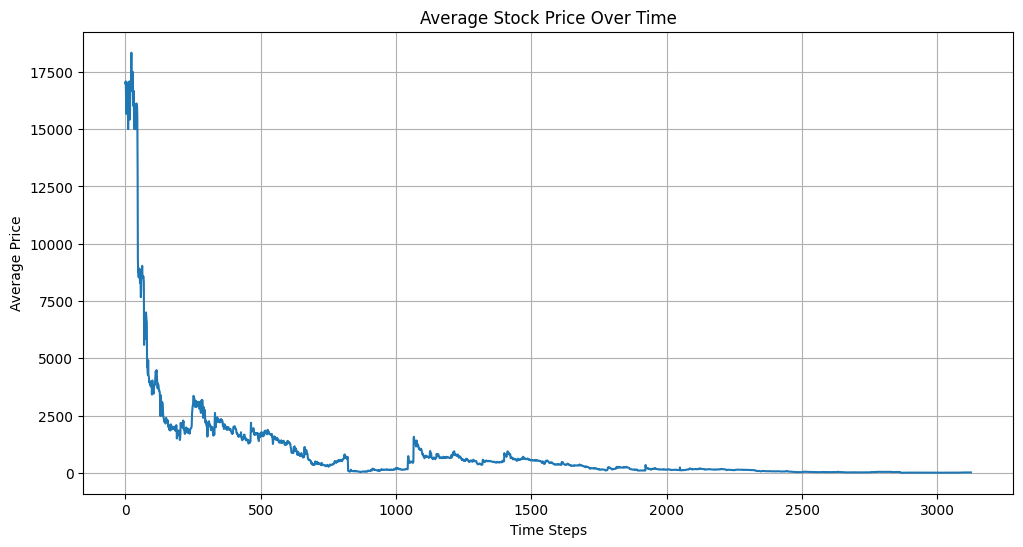

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(average)), average)
plt.title('Average Stock Price Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Average Price')
plt.grid(True)
plt.show()

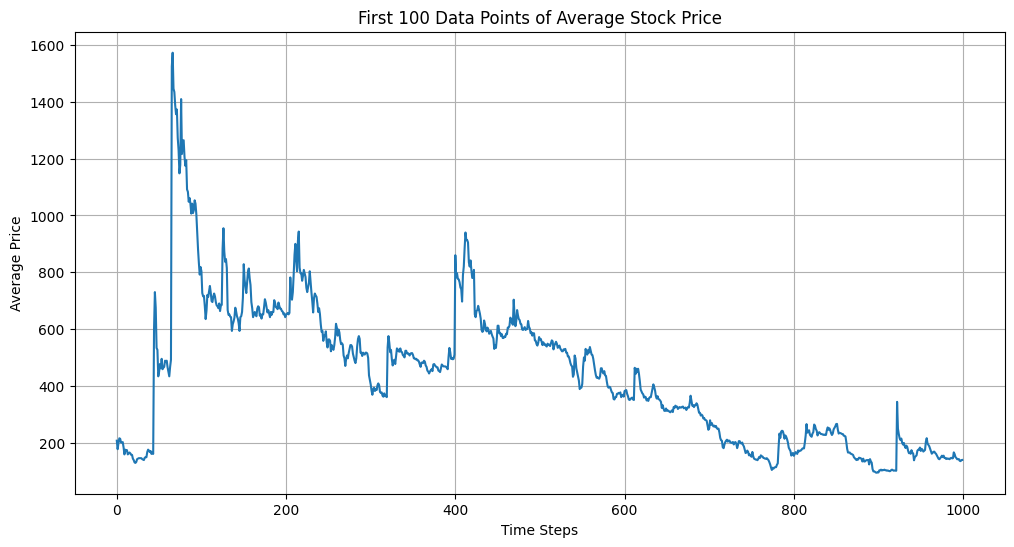

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(range(1000), average[1000:2000])
plt.title('First 100 Data Points of Average Stock Price')
plt.xlabel('Time Steps')
plt.ylabel('Average Price')
plt.grid(True)
plt.show()

# Tamaño de cada conjunto de datos

In [24]:
num_train_samples = int(0.7 * len(raw_data))
num_val_samples = int(0.15 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 2187
num_val_samples: 468
num_test_samples: 470


# Normalizacion de Datos

In [25]:
# Normalizar todas las columnas numéricas
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [26]:
average = raw_data[:, -1]

# Division de Datos: entrenamiento, validación y prueba

In [27]:
sampling_rate = 1
sequence_length = 7 # número de neuronas recurrentes (seq_length)
delay = sampling_rate * (sequence_length + 1 - 1)
batch_size = 32


train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=average[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=average[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=average[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples + delay)

In [28]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (32, 7, 5)
targets shape: (32,)


# LSTM MODEL

In [29]:
# Create a more robust LSTM model with regularization
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16,
                #recurrent_dropout=0.2,
                )(inputs) 
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Print model summary to understand architecture
model.summary()

# Replace the learning rate schedule with a fixed learning rate

callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Increase epochs to give model more chance to learn
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=callbacks,
)

test_results = model.evaluate(test_dataset)
print(f"Test MSE: {test_results[0]:.4f}")
print(f"Test MAE: {test_results[1]:.4f}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 7, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,425 (5.57 KB)

 Trainable params: 1,425 (5.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4896 - mae: 0.1964 - val_loss: 0.0011 - val_mae: 0.0320
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1466 - mae: 0.0957 - val_loss: 0.0027 - val_mae: 0.0517
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0289 - mae: 0.0581 - val_loss: 0.0010 - val_mae: 0.0311
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0172 - mae: 0.0466 - val_loss: 4.0232e-04 - val_mae: 0.0194
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0114 - mae: 0.0382 - val_loss: 3.1268e-04 - val_mae: 0.0170
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086 - mae: 0.0333 - val_loss: 3.5007e-04 - val_mae: 0.0182
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0088 - mae: 0.0326 - val_loss: 2.8282e-04 - val_mae: 0.0163
Epoch 8/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091 - mae: 0.0326 - val_loss: 1.0034e-04 - val_mae: 0.0093
Epoch 9/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - 

## Curva de perdida vs iteraciones (epochs)

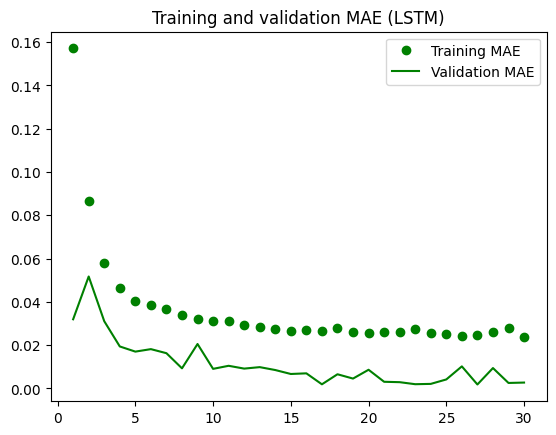

In [30]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "go", label="Training MAE")
plt.plot(epochs, val_loss, "g", label="Validation MAE")
plt.title("Training and validation MAE (LSTM)")
plt.legend()
plt.show()

## Predicciones vs Valor verdadero

In [31]:
# Predict using the trained model
predictions = model.predict(test_dataset)
predictions = predictions.flatten()  # Flatten to 1D if needed
#predictions = predictions * average_std + average_mean# Rescale predictions

# Extract true values for plotting (optional: flatten to 1D if needed)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true = y_true.flatten()  # Flatten to 1D if needed
#y_true = y_true * average_std + average_mean  # Rescale true values

print("Predictions shape:", predictions.shape)
print("True values shape:", y_true.shape)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predictions shape: (450,)
True values shape: (450,)


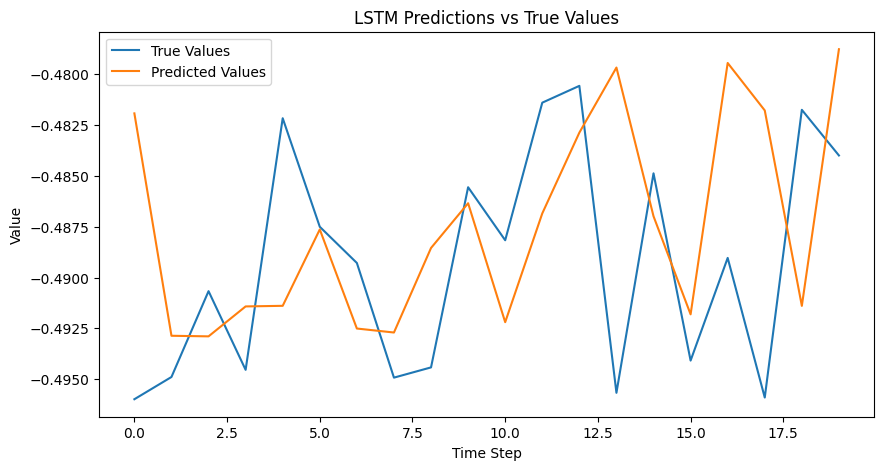

In [32]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_true[40:60], label='True Values')
plt.plot(predictions[40:60], label='Predicted Values')
plt.title('LSTM Predictions vs True Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

# GRU MODEL

In [33]:
# Create a more robust GRU model with regularization
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16,
                #recurrent_dropout=0.2,
                )(inputs) 
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Print model summary to understand architecture
model.summary()

# Replace the learning rate schedule with a fixed learning rate

callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Increase epochs to give model more chance to learn
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=callbacks,
)

test_results = model.evaluate(test_dataset)
print(f"Test MSE: {test_results[0]:.4f}")
print(f"Test MAE: {test_results[1]:.4f}")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 7, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 16)             │         1,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2366 - mae: 0.1321 - val_loss: 0.0014 - val_mae: 0.0370
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0391 - mae: 0.0630 - val_loss: 2.5746e-05 - val_mae: 0.0049
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0131 - mae: 0.0347 - val_loss: 3.6390e-05 - val_mae: 0.0059
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - mae: 0.0288 - val_loss: 6.9167e-05 - val_mae: 0.0082
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - mae: 0.0269 - val_loss: 2.3891e-04 - val_mae: 0.0154
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - mae: 0.0279 - val_loss: 4.8559e-05 - val_mae: 0.0068
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0049 - mae: 0.0238 - val_loss: 8.5997e-05 - val_mae: 0.0092
Epoch 8/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046 - mae: 0.0229 - val_loss: 3.0113e-04 - val_mae: 0.0173
Epoch 9/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms

## curva de perdida vs iteraciones

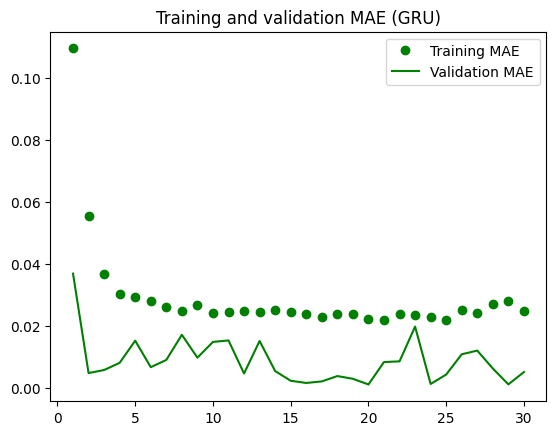

In [34]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "go", label="Training MAE")
plt.plot(epochs, val_loss, "g", label="Validation MAE")
plt.title("Training and validation MAE (GRU)")
plt.legend()
plt.show()

## Predicciones vs valor verdadero

In [35]:
# Predict using the trained model
predictions = model.predict(test_dataset)
predictions = predictions.flatten()  # Flatten to 1D if needed
#predictions = predictions * average_std + average_mean# Rescale predictions

# Extract true values for plotting (optional: flatten to 1D if needed)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true = y_true.flatten()  # Flatten to 1D if needed
#y_true = y_true * average_std + average_mean  # Rescale true values

print("Predictions shape:", predictions.shape)
print("True values shape:", y_true.shape)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predictions shape: (450,)
True values shape: (450,)


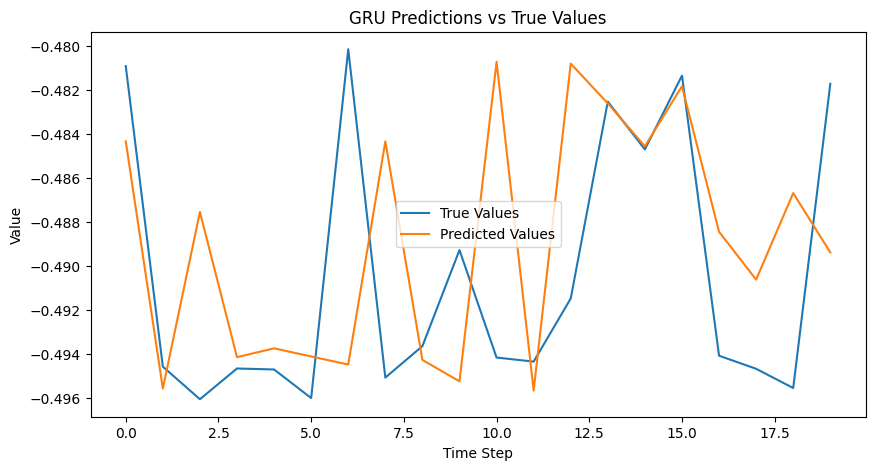

In [36]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_true[40:60], label='True Values')
plt.plot(predictions[40:60], label='Predicted Values')
plt.title('GRU Predictions vs True Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()